In [ ]:
!pip install imageio

from IPython import display
import imageio  # for GIF saving
from io import BytesIO  # for figure saving
import imageio
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

In [ ]:
# maze game environmet
class MazeEnvironment:
    def __init__(self):
        # 7x7 grid-based maze
        self.maze = np.zeros((7, 7))
        self.start_pos = (0, 0)  # start point
        self.goal_pos = (6, 6)   # goal
        self.current_pos = self.start_pos
        # set obstacles (-1 representing obstacle)
        self.maze[0, 6] = -1
        self.maze[1, 1] = -1
        self.maze[1, 3] = -1
        self.maze[1, 4] = -1
        self.maze[2, 1] = -1
        self.maze[2, 4] = -1
        self.maze[2, 5] = -1
        self.maze[3, 1] = -1
        self.maze[3, 5] = -1
        self.maze[4, 4] = -1
        self.maze[5, 1] = -1
        self.maze[5, 2] = -1
        self.maze[5, 5] = -1
        self.maze[6, 0] = -1
        self.maze[6, 1] = -1
        # action spave UP(0), DOWN(1), LEFT(2), RIGHT(3)
        self.actions = [(0, -1), (0, 1), (-1, 0), (1, 0)]

    def reset(self):
        self.current_pos = self.start_pos
        return self.current_pos

    def step(self, action):
        # calculate new position
        move = self.actions[action]
        new_pos = (self.current_pos[0] + move[0],
                  self.current_pos[1] + move[1])

        # check if overboard
        if (0 <= new_pos[0] < 7 and 0 <= new_pos[1] < 7):
            # chech if bump into obstacles
            if self.maze[new_pos] != -1:
                self.current_pos = new_pos

        # calculate reward
        if self.current_pos == self.goal_pos:
            reward = 100  # reward for reaching the goal
            done = True
        elif self.maze[self.current_pos] == -1:
            reward = -50  # penalty for bumpping into a obstacle
            done = False
        else:
            reward = -1   # each step incurs a small penalty to encourage efficiency
            done = False

        return self.current_pos, reward, done

In [ ]:
# define Q-learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size[0], state_size[1], action_size))
        self.epsilon = 0.1  # exploration rate
        self.alpha = 0.1    # learning rate
        self.gamma = 0.9    # discount factor

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)  # 随机探索
        else:
            return np.argmax(self.q_table[state[0], state[1]])  # 利用

    def update(self, state, action, reward, next_state, done):
        current_q = self.q_table[state[0], state[1], action]
        max_next_q = np.max(self.q_table[next_state[0], next_state[1]])
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state[0], state[1], action] = new_q

In [ ]:
# define visualization function
def visualize_maze(env, agent_pos, episode, total_reward):
    fig = plt.figure(figsize=(10, 10))
    maze_display = env.maze.copy()
    maze_display[agent_pos] = 0.5  # use 0.5 for agent position
    maze_display[env.goal_pos] = 0.8  # use 0.8 for goal position
    plt.imshow(maze_display, cmap='cool')
    plt.title(f'Episode: {episode}, Total Reward: {total_reward}')
    plt.colorbar()

    # save the figure into buffer
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight')
    buf.seek(0)
    image = imageio.imread(buf)
    buf.close()
    plt.close()

    # display in Colab
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close()
    time.sleep(0.1)

    return image

In [ ]:
# define train function
def train():
    env = MazeEnvironment()
    agent = QLearningAgent(state_size=(7, 7), action_size=4)
    episodes = 1000
    rewards_history = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        step = 0

        while not done and step < 50:  # restrict the max steps
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1

            # do visualization every 100 episode
            if episode % 100 == 0:
                visualize_maze(env, state, episode, total_reward)

        rewards_history.append(total_reward)

        # gradually reduce exploration rate
        if agent.epsilon > 0.01:
            agent.epsilon *= 0.995

    # plot learning curve
    plt.figure(figsize=(10, 5))
    plt.plot(rewards_history)
    plt.title('Learning Curve')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

    return agent, env

In [ ]:
# define test function
def test(agent, env, gif_path='maze_test.gif'):
    state = env.reset()
    done = False
    total_reward = 0
    step = 0
    frames = []  # save every frame

    while not done and step < 50:
        action = np.argmax(agent.q_table[state[0], state[1]])
        next_state, reward, done = env.step(action)
        # fetch current frame
        frame = visualize_maze(env, next_state, "Test", total_reward)
        frames.append(frame)
        state = next_state
        total_reward += reward
        step += 1

    print(f"Test completed. Total reward: {total_reward}")

    # save as GIF
    print("Saving GIF...")
    imageio.mimsave(gif_path, frames, fps=2)  # use fps to control the speed
    print(f"GIF saved as {gif_path}")

    # display GIF in Colab
    from IPython.display import Image
    display.display(Image(filename=gif_path))


<Figure size 640x480 with 0 Axes>

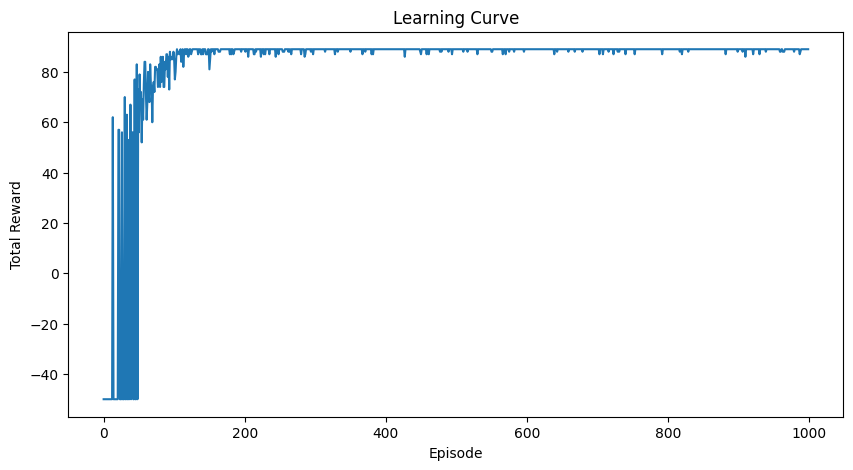

In [ ]:
# train
agent, env = train()

<Figure size 640x480 with 0 Axes>

Test completed. Total reward: 89
Saving GIF...
GIF saved as maze_test.gif


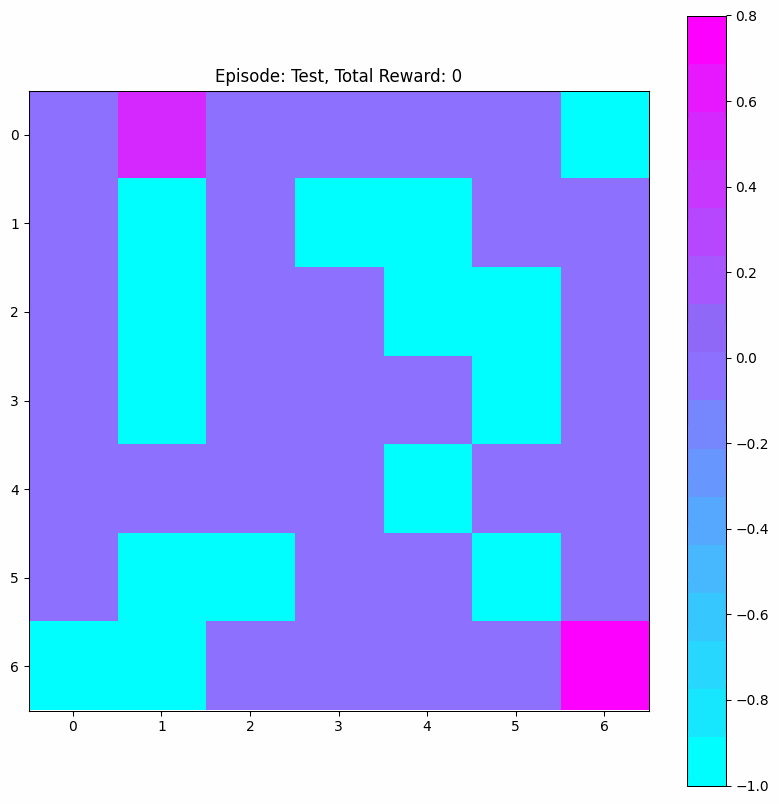

In [ ]:
# test
test(agent, env, gif_path='maze_test.gif')